Chapter 1: Basic Concepts

In [4]:
import numpy as np
import random

'''
ooo
oox
xoI
'''

class GridWorldEnv:

    def __init__(self, forbidden_states=None, target_state=None, rewards=None):
        self.num_states = 9
        self.num_actions = 5
        # State mapping: 0=s1, 1=s2, ..., 8=s9
        # Action mapping: 0=up, 1=right, 2=down, 3=left, 4=still

        # Define coordinates for each state (optional, for easier logic)
        # (row, col), 0-indexed
        self.state_coords = {
            0: (0, 0), 1: (0, 1), 2: (0, 2),
            3: (1, 0), 4: (1, 1), 5: (1, 2), # s6 is forbidden
            6: (2, 0), 7: (2, 1), 8: (2, 2)  # s7 is forbidden, s9 is target
        }
        self.coords_state = {v: k for k, v in self.state_coords.items()}
        self.rows, self.cols = 3, 3

        self.forbidden_states = forbidden_states if forbidden_states is not None else [5, 6] 
        self.target_state = target_state if target_state is not None else 8 

        # r_boundary = -1, r_forbidden = -1, r_target = +1, r_other = 0
        self.rewards = rewards if rewards is not None else {
            'boundary': -1.0, # 越界
            'forbidden': -1.0, # 禁区
            'target': 1.0, # 目标
            'other': 0.0 # else
        }

    def step(self, state, action):

        if state not in range(self.num_states):
            raise ValueError(f"Invalid state: {state}")
        if action not in range(self.num_actions):
            raise ValueError(f"Invalid action: {action}")

        row, col = self.state_coords[state]
        next_row, next_col = row, col
        reward = self.rewards['other'] 

        # Calculate potential next position based on action
        if action == 0: # up
            next_row = row - 1
        elif action == 1: # right
            next_col = col + 1
        elif action == 2: # down
            next_row = row + 1
        elif action == 3: # left
            next_col = col - 1
        # action == 4 (still) 

        # Check for boundary collisions
        hit_boundary = False
        if next_row < 0 or next_row >= self.rows or \
           next_col < 0 or next_col >= self.cols:
            next_row, next_col = row, col
            reward = self.rewards['boundary']
            hit_boundary = True

        next_state = self.coords_state[(next_row, next_col)]

        # Check if attempted move was into a forbidden cell 
        attempted_row, attempted_col = row, col
        if action == 0: attempted_row -= 1
        elif action == 1: attempted_col += 1
        elif action == 2: attempted_row += 1
        elif action == 3: attempted_col -= 1

        # Find state index of attempted cell, if within grid
        attempted_state = -1
        if 0 <= attempted_row < self.rows and 0 <= attempted_col < self.cols:
             attempted_state = self.coords_state[(attempted_row, attempted_col)]

        reward = self.get_reward(state, action)

        next_state = self.get_next_state_deterministic(state, action)

        return next_state, reward

    def get_next_state_deterministic(self, state, action):

        # Handle boundary bounces first
        row, col = self.state_coords[state]
        next_row, next_col = row, col

        if action == 0: next_row -= 1
        elif action == 1: next_col += 1
        elif action == 2: next_row += 1
        elif action == 3: next_col -= 1

        if next_row < 0 or next_row >= self.rows or next_col < 0 or next_col >= self.cols:
            # If move goes out of bounds, stay in the same state
            return state
        else:
            # If move is within bounds, return the state corresponding to the new coordinates
            return self.coords_state[(next_row, next_col)]

    def get_reward(self, state, action):

        row, col = self.state_coords[state]
        target_row, target_col = self.state_coords[self.target_state]
        next_row, next_col = row, col

        if action == 0: next_row -= 1
        elif action == 1: next_col += 1
        elif action == 2: next_row += 1
        elif action == 3: next_col -= 1
        # action 4: stay still

        # 1. Check Boundary Collision
        if next_row < 0 or next_row >= self.rows or next_col < 0 or next_col >= self.cols:
            return self.rewards['boundary']

        # 2. Check if next state is forbidden
        next_state_if_valid = self.coords_state.get((next_row, next_col), -1)
        if next_state_if_valid in self.forbidden_states:
             # Special case: attempting to stay still in a forbidden state is also forbidden reward
             if action == 4 and state in self.forbidden_states: # stay still
                  return self.rewards['forbidden']
             # Check if the *move* leads into forbidden
             intended_next_state = self.get_next_state_deterministic(state, action)
             if intended_next_state in self.forbidden_states:
                  return self.rewards['forbidden']

             if (state, action) in [(2, 2), (3, 2), (4, 1), (5, 1), (5, 4), (6, 0), (6, 3), (7, 4)]: return self.rewards['forbidden'] # enter forbidden table

        # 3. Check if next state is target
        intended_next_state = self.get_next_state_deterministic(state, action)
        if intended_next_state == self.target_state:
             # Check specific (state, action) pairs leading to target reward in Table 1.3
             if (state, action) in [(5, 2), (7, 1), (8, 4)]: return self.rewards['target'] # enter target table

        # 4. Otherwise, reward is 'other'
        # Handle staying still at target
        if state == self.target_state and action == 4:
             return self.rewards['target'] # target stay still

        # Handle specific 0 reward cases from Table 1.3 not covered above
        if (state, action) in [(0, 1), (0, 2), (0, 4),
                             (1, 1), (1, 2), (1, 3), (1, 4),
                             (2, 3), (2, 4),
                             (3, 0), (3, 1), (3, 4),
                             (4, 0), (4, 2), (4, 3), (4, 4),
                             (5, 0), (5, 2),
                             (6, 1), (6, 2), (6, 4),
                             (7, 0), (7, 1), (7, 2),
                             (8, 0), (8, 3)]: return self.rewards['other'] # other (state, action), rewards == 0

        # Map (state, action) -> reward
        reward_map = {
            # state 0 (s1)
            (0, 0): self.rewards['boundary'], (0, 1): self.rewards['other'], (0, 2): self.rewards['other'], (0, 3): self.rewards['boundary'], (0, 4): self.rewards['other'],
            # state 1 (s2)
            (1, 0): self.rewards['boundary'], (1, 1): self.rewards['other'], (1, 2): self.rewards['other'], (1, 3): self.rewards['other'], (1, 4): self.rewards['other'],
            # state 2 (s3)
            (2, 0): self.rewards['boundary'], (2, 1): self.rewards['boundary'], (2, 2): self.rewards['forbidden'], (2, 3): self.rewards['other'], (2, 4): self.rewards['other'],
            # state 3 (s4)
            (3, 0): self.rewards['other'], (3, 1): self.rewards['other'], (3, 2): self.rewards['forbidden'], (3, 3): self.rewards['boundary'], (3, 4): self.rewards['other'],
            # state 4 (s5)
            (4, 0): self.rewards['other'], (4, 1): self.rewards['forbidden'], (4, 2): self.rewards['other'], (4, 3): self.rewards['other'], (4, 4): self.rewards['other'],
            # state 5 (s6) - Forbidden state
            (5, 0): self.rewards['other'], (5, 1): self.rewards['boundary'], (5, 2): self.rewards['target'], (5, 3): self.rewards['other'], (5, 4): self.rewards['forbidden'],
             # state 6 (s7) - Forbidden state
            (6, 0): self.rewards['other'], (6, 1): self.rewards['other'], (6, 2): self.rewards['boundary'], (6, 3): self.rewards['boundary'], (6, 4): self.rewards['forbidden'],
             # state 7 (s8)
            (7, 0): self.rewards['other'], (7, 1): self.rewards['target'], (7, 2): self.rewards['boundary'], (7, 3): self.rewards['forbidden'], (7, 4): self.rewards['other'],
             # state 8 (s9) - Target state
            (8, 0): self.rewards['forbidden'], (8, 1): self.rewards['boundary'], (8, 2): self.rewards['boundary'], (8, 3): self.rewards['other'], (8, 4): self.rewards['target'],
        }
        return reward_map.get((state, action), self.rewards['other']) 


# --- Policy Definition ---

def define_deterministic_policy(policy_map):

    def policy(state):
        return policy_map.get(state, random.choice(range(5))) # Default to random if state not in map
    return policy

def define_stochastic_policy(policy_prob_map):

    def policy(state):
        if state not in policy_prob_map:
            # Default to uniform random if state not specified
            return random.choice(range(5))
        
        probs = policy_prob_map[state]
        actions = list(probs.keys())
        probabilities = list(probs.values())
        
        return np.random.choice(actions, p=probabilities)
    return policy

# --- Simulation and Return Calculation ---

def simulate_episode(env, policy, start_state, max_steps=100):

    trajectory = []
    state = start_state
    for _ in range(max_steps):
        action = policy(state)
        next_state, reward = env.step(state, action)
        trajectory.append((state, action, reward, next_state))
        state = next_state

    return trajectory

def calculate_return(trajectory, gamma):

    discounted_return = 0.0
    # Iterate backwards through rewards, applying discount factor
    rewards = [step[2] for step in trajectory] # Extract rewards R_1, R_2, ...
    for i, reward in enumerate(rewards):
         discounted_return += (gamma**i) * reward
         
    return discounted_return


# 1. Create the environment
env = GridWorldEnv()

# 2. Define a policy 
# s1->a2(R), s2->a3(D), s3->a4(L), s4->a2(R), s5->a3(D), s6->a3(D), s7->a2(R), s8->a2(R), s9->a5(S)
policy_map_fig1_6a = {
    0: 1,  # s1 -> right
    1: 2,  # s2 -> down
    2: 3,  # s3 -> left (back to s2)
    3: 1,  # s4 -> right
    4: 2,  # s5 -> down
    5: 2,  # s6 -> down (to target s9)
    6: 1,  # s7 -> right
    7: 1,  # s8 -> right (to target s9)
    8: 4,  # s9 -> still
}
policy_fig1_6a = define_deterministic_policy(policy_map_fig1_6a)

# 3. Simulate an episode starting from s1 (state 0)
start_state = 0
# Set max_steps reasonably high to see behavior, though trajectory might repeat
trajectory = simulate_episode(env, policy_fig1_6a, start_state, max_steps=100)

print(f"Simulating Policy from Figure 1.6a starting at state {start_state}:")
print("Trajectory (state, action, reward, next_state):")
# Let's print state indices + 1 to match s1, s2 etc.
for (s, a, r, ns) in trajectory:
    print(f"  s{s+1} --(a{a+1}, r={r})--> s{ns+1}")

# 4. Calculate the discounted return (G_0)
gamma = 0.9 # Discount factor used in later chapters, apply here for illustration
discounted_return = calculate_return(trajectory, gamma)
print(f"\nDiscounted Return (G_0) with gamma={gamma}: {discounted_return:.4f}")

# Trajectory: s1 -(a2, r=0)-> s2 -(a3, r=0)-> s5 -(a3, r=0)-> s8 -(a2, r=1)-> s9
undiscounted_return_4_steps = sum(step[2] for step in trajectory[:4])
print(f"Undiscounted Return (first 4 steps, like book example): {undiscounted_return_4_steps}")


policy_prob_map_tbl1_2 = {
    0: {0: 0.0, 1: 0.5, 2: 0.5, 3: 0.0, 4: 0.0}, # s1
    1: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0}, # s2
    2: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0, 4: 0.0}, # s3
    3: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0}, # s4
    4: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0}, # s5
    5: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0, 4: 0.0}, # s6
    6: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0}, # s7
    7: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0, 4: 0.0}, # s8
    8: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0}, # s9
}
policy_tbl1_2 = define_stochastic_policy(policy_prob_map_tbl1_2)

for i in range(10): # Run 10 sample episodes
    trajectory_stoch = simulate_episode(env, policy_tbl1_2, start_state, max_steps=100)
    print(f"\nEpisode {i+1}:")
    for (s, a, r, ns) in trajectory_stoch:
        print(f"  s{s+1} --(a{a+1}, r={r})--> s{ns+1}")
    discounted_return_stoch = calculate_return(trajectory_stoch, gamma)
    print(f"  Discounted Return (G_0) with gamma={gamma}: {discounted_return_stoch:.4f}")

Simulating Policy from Figure 1.6a starting at state 0:
Trajectory (state, action, reward, next_state):
  s1 --(a2, r=0.0)--> s2
  s2 --(a3, r=0.0)--> s5
  s5 --(a3, r=0.0)--> s8
  s8 --(a2, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)--> s9
  s9 --(a5, r=1.0)-->

Chapter 2: State Values and Bellman Equation

Policy evaluation

In [96]:
import numpy as np

class FourStateEnv:

    def __init__(self, gamma=0.9):
        self.num_states = 4
        self.gamma = gamma
        # s1: 0.5 -> s2 (r=-1), 0.5 -> s3 (r=0)
        # s2: 1.0 -> s4 (r=1)
        # s3: 1.0 -> s4 (r=1)
        # s4: 1.0 -> s4 (r=1)

    def get_r_pi_and_P_pi(self, policy_type='fig2.5'):

        r_pi = np.zeros(self.num_states)
        P_pi = np.zeros((self.num_states, self.num_states))

        if policy_type == 'fig2.5':
            # State 0 (s1): Stochastic policy
            # Action a2 (right): leads to s2 (state 1), reward -1
            # Action a3 (down): leads to s3 (state 2), reward 0
            # Policy: pi(a2|s1)=0.5, pi(a3|s1)=0.5
            p_s1_a2 = 0.5
            r_s1_a2 = -1.0
            next_s_s1_a2 = 1 # s2

            p_s1_a3 = 0.5
            r_s1_a3 = 0.0
            next_s_s1_a3 = 2 # s3

            r_pi[0] = p_s1_a2 * r_s1_a2 + p_s1_a3 * r_s1_a3 # -0.5
            P_pi[0, next_s_s1_a2] = p_s1_a2 # P(s2 | s1) = 0.5
            P_pi[0, next_s_s1_a3] = p_s1_a3 # P(s3 | s1) = 0.5

            # State 1 (s2): Deterministic policy -> s4 (state 3), reward 1
            r_pi[1] = 1.0
            P_pi[1, 3] = 1.0

            # State 2 (s3): Deterministic policy -> s4 (state 3), reward 1
            r_pi[2] = 1.0
            P_pi[2, 3] = 1.0

            # State 3 (s4): Deterministic policy -> s4 (state 3), reward 1
            r_pi[3] = 1.0
            P_pi[3, 3] = 1.0

        else:
             # State 0 (s1): Deterministic policy -> s3 (state 2), reward 0
             r_pi[0] = 0.0
             P_pi[0, 2] = 1.0
             # State 1 (s2): Deterministic policy -> s4 (state 3), reward 1
             r_pi[1] = 1.0
             P_pi[1, 3] = 1.0
             # State 2 (s3): Deterministic policy -> s4 (state 3), reward 1
             r_pi[2] = 1.0
             P_pi[2, 3] = 1.0
             # State 3 (s4): Deterministic policy -> s4 (state 3), reward 1
             r_pi[3] = 1.0
             P_pi[3, 3] = 1.0


        return r_pi, P_pi

    def get_dynamics_for_q(self):

        # p[state][action] = [(prob, next_state, reward), ...]
        p = {
            0: { # State s1
                0: [(1.0, 1, -1.0)], # action 'right' -> s2, r=-1
                1: [(1.0, 2, 0.0)],  # action 'down'  -> s3, r=0
                # 2: [(1.0, 0, -1.0)] # action 'up' -> s1, r=-1 (boundary)
            },
            1: { # State s2
                0: [(1.0, 3, 1.0)]   # action 'policy' -> s4, r=1
            },
            2: { # State s3
                0: [(1.0, 3, 1.0)]   # action 'policy' -> s4, r=1
            },
            3: { # state s4
                0: [(1.0, 3, 1.0)]   # action 'policy' -> s4, r=1
            }
        }
        return p


# --- Policy Evaluation Algorithms ---

def policy_evaluation_direct(r_pi, P_pi, gamma):

    num_states = len(r_pi)
    I = np.identity(num_states)
    inv = np.linalg.inv(I - gamma * P_pi)
    v_pi = inv @ r_pi

    return v_pi

def policy_evaluation_iterative(r_pi, P_pi, gamma, tol=1e-6, max_iter=10000):

    num_states = len(r_pi)
    v_pi = np.zeros(num_states) # Initialize values to zero
    for i in range(max_iter):
        v_prev = v_pi.copy()
        v_pi = r_pi + gamma * (P_pi @ v_prev)
        # Check for convergence
        if np.max(np.abs(v_pi - v_prev)) < tol:
            print(f"Iterative policy evaluation converged after {i+1} iterations.")
            break

    return v_pi

# --- Action Value Calculation ---

def calculate_action_values(env, v_pi, gamma):

    q_pi = {}
    dynamics = env.get_dynamics_for_q() # Get simplified dynamics

    for state in range(env.num_states):
        q_pi[state] = {}
        if state in dynamics:
            for action in dynamics[state]:
                action_value = 0.0
                # Dynamics assumes a list of possible outcomes for (s,a)
                for prob, next_state, reward in dynamics[state][action]:
                    action_value += prob * (reward + gamma * v_pi[next_state])
                q_pi[state][action] = action_value
    return q_pi

print("Running Policy Evaluation for Fig 2.5 Policy")
env = FourStateEnv(gamma=0.9)
r_pi_fig2_5, P_pi_fig2_5 = env.get_r_pi_and_P_pi(policy_type='fig2.5')

print("\nr_pi (Expected Rewards under policy):")
print(r_pi_fig2_5)
print("\nP_pi (Transition Matrix under policy):")
print(P_pi_fig2_5)

# 1. Direct Solution
print("\nCalculating v_pi using Direct Method:")
v_pi_direct = policy_evaluation_direct(r_pi_fig2_5, P_pi_fig2_5, env.gamma)
print("v_pi (Direct):", np.round(v_pi_direct, 4)) 

# 2. Iterative Solution
print("\nCalculating v_pi using Iterative Method:")
v_pi_iterative = policy_evaluation_iterative(r_pi_fig2_5, P_pi_fig2_5, env.gamma, tol=1e-6)
print("v_pi (Iterative):", np.round(v_pi_iterative, 4))

# v(s4)=10, v(s3)=10, v(s2)=10, v(s1)=8.5
print("\nExpected values from book")
print("v(s1)=8.5, v(s2)=10.0, v(s3)=10.0, v(s4)=10.0")

# 3. Calculate Action Values q_pi(s,a)
print("\nCalculating q_pi(s,a) based on iterative v_pi:")
q_pi = calculate_action_values(env, v_pi_iterative, env.gamma)
print("q_pi values:")
for state, actions in q_pi.items():
    print(f"  State {state} (s{state+1}):")
    for action, value in actions.items():
        print(f"    Action {action}: {value:.4f}")


# q(s1, a2) = -1 + gamma*v(s2) = -1 + 0.9 * 10 = 8.0
# q(s1, a3) = 0 + gamma*v(s3) = 0 + 0.9 * 10 = 9.0
print("\nExpected q_pi for s1 from book")
print("q(s1, right) = 8.0")
print("q(s1, down) = 9.0")


print("\nRunning Policy Evaluation for Fig 2.4 Policy")
r_pi_fig2_4, P_pi_fig2_4 = env.get_r_pi_and_P_pi(policy_type='fig2.4')
print("\nr_pi (Expected Rewards under policy):")
print(r_pi_fig2_4)
print("\nP_pi (Transition Matrix under policy):")
print(P_pi_fig2_4)
v_pi_iterative_fig2_4 = policy_evaluation_iterative(r_pi_fig2_4, P_pi_fig2_4, env.gamma, tol=1e-8)
print("v_pi (Iterative):", np.round(v_pi_iterative_fig2_4, 4))
print("\nExpected values from book")
print("v(s1)=9.0, v(s2)=10.0, v(s3)=10.0, v(s4)=10.0")

Running Policy Evaluation for Fig 2.5 Policy

r_pi (Expected Rewards under policy):
[-0.5  1.   1.   1. ]

P_pi (Transition Matrix under policy):
[[0.  0.5 0.5 0. ]
 [0.  0.  0.  1. ]
 [0.  0.  0.  1. ]
 [0.  0.  0.  1. ]]

Calculating v_pi using Direct Method:
v_pi (Direct): [ 8.5 10.  10.  10. ]

Calculating v_pi using Iterative Method:
Iterative policy evaluation converged after 133 iterations.
v_pi (Iterative): [ 8.5 10.  10.  10. ]

Expected values from book
v(s1)=8.5, v(s2)=10.0, v(s3)=10.0, v(s4)=10.0

Calculating q_pi(s,a) based on iterative v_pi:
q_pi values:
  State 0 (s1):
    Action 0: 8.0000
    Action 1: 9.0000
  State 1 (s2):
    Action 0: 10.0000
  State 2 (s3):
    Action 0: 10.0000
  State 3 (s4):
    Action 0: 10.0000

Expected q_pi for s1 from book
q(s1, right) = 8.0
q(s1, down) = 9.0

Running Policy Evaluation for Fig 2.4 Policy

r_pi (Expected Rewards under policy):
[0. 1. 1. 1.]

P_pi (Transition Matrix under policy):
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]


Chapter 3: Optimal State Values and Bellman Optimality Equation

In [49]:
import numpy as np
import time 

'''
ox
oI 
'''

class SimpleFourStateEnvCh3_Stay:

    def __init__(self, gamma=0.9):
        self.num_states = 4
        self.num_actions = 5 # 0:up, 1:right, 2:down, 3:left, 4:stay
        self.gamma = gamma
        self.state_coords = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
        self.coords_state = {v: k for k, v in self.state_coords.items()}
        self.rows, self.cols = 2, 2
        self.forbidden_state = 1 # s2
        self.target_state = 3    # s4

        self.rewards = {
            'boundary': -1.0,
            'forbidden': -1.0, 
            'target': 1.0,     
            'stay_target': 1.0,
            'other': 0.0
        }
        # Pre-calculate dynamics: p[s, a, s'] and r[s, a]
        self.p, self.r = self._build_dynamics_and_rewards()

    def _build_dynamics_and_rewards(self):
        p = np.zeros((self.num_states, self.num_actions, self.num_states))
        r = np.zeros((self.num_states, self.num_actions))

        for s in range(self.num_states):
            if s == self.target_state:
                 for a in range(self.num_actions):
                     p[s, a, s] = 1.0 # Stay in target state
                     r[s, a] = self.rewards['stay_target'] 
                 continue 
            
            current_row, current_col = self.state_coords[s]
            for a in range(self.num_actions):
                next_row, next_col = current_row, current_col
                reward = self.rewards['other']

                if a == 0: next_row -= 1    # up
                elif a == 1: next_col += 1  # right
                elif a == 2: next_row += 1  # down
                elif a == 3: next_col -= 1  # left
                elif a == 4: pass           # stay

                # Check boundary
                if next_row < 0 or next_row >= self.rows or next_col < 0 or next_col >= self.cols:
                    next_state = s 
                    reward = self.rewards['boundary']
                else:
                    next_state = self.coords_state[(next_row, next_col)]
                    if next_state == self.target_state:
                        reward = self.rewards['target']
                    elif next_state == self.forbidden_state:
                         reward = self.rewards['forbidden']
                    elif a == 4:
                         if s == self.forbidden_state:
                             reward = self.rewards['other'] 


                p[s, a, next_state] = 1.0 # Deterministic
                r[s, a] = reward
        return p, r

    def get_dynamics_and_rewards(self):
        return self.p, self.r

    def is_terminal(self, state):
         return state == self.target_state 

# Value Iteration Algorithm
def value_iteration(env, gamma, tol=1e-8, max_iter=1000):
    """ Performs Value Iteration """
    num_states = env.num_states
    num_actions = env.num_actions 
    p, r = env.get_dynamics_and_rewards()
    v_star = np.zeros(num_states)

    print(f"Starting Value Iteration (gamma={gamma}, tol={tol})")
    for i in range(max_iter):
        v_prev = v_star.copy()
        delta = 0
        for s in range(num_states):
            action_values = np.zeros(num_actions)
            for a in range(num_actions): 
                action_values[a] = r[s, a] + gamma * np.sum(p[s, a, :] * v_prev)

            best_value = np.max(action_values)
            delta = max(delta, np.abs(best_value - v_prev[s]))
            v_star[s] = best_value

        if delta < tol:
            print(f"Value Iteration converged after {i+1} iterations.")
            return v_star, i + 1
    print(f"Value Iteration did not converge after {max_iter} iterations.")
    return v_star, max_iter

# Optimal Policy Extraction
def extract_policy(env, v_star, gamma):
    """
    Extracts the optimal deterministic policy pi* from v*.
    Forces action 'stay' (index 4) for the target state.
    """
    num_states = env.num_states
    num_actions = env.num_actions
    p, r = env.get_dynamics_and_rewards()
    pi_star = np.zeros(num_states, dtype=int)
    q_star = np.zeros((num_states, num_actions))

    print("\nCalculating Optimal Q-values (q*) based on v*:")
    for s in range(num_states):
        if s == env.target_state:
            pi_star[s] = 4 # Action index 4 is 'stay'
            # Q-values for target state under this dynamic (r=1, loop) are all 10
            q_star[s, :] = r[s, 0] + gamma * np.sum(p[s, 0, :] * v_star)
            continue

        # For other states, find the best action based on q*
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            action_values[a] = r[s, a] + gamma * np.sum(p[s, a, :] * v_star)

        q_star[s, :] = action_values
        pi_star[s] = np.argmax(action_values)

    print(np.round(q_star, 4))
    return pi_star

def print_policy(policy, env, shape=(2,2)):
    action_symbols = {0: '^ (up)', 1: '> (right)', 2: 'v (down)', 3: '< (left)', 4: 'o (stay)'}
    policy_grid = np.full(shape, '', dtype=object)
    coords_state = env.coords_state

    for r_idx in range(shape[0]):
        for c_idx in range(shape[1]):
            state_idx = coords_state.get((r_idx, c_idx), -99)
            if state_idx == -99: continue

            action_idx = policy[state_idx]
            # Use get for safer dictionary access
            policy_grid[r_idx, c_idx] = action_symbols.get(action_idx, 'ERR')

    print("Optimal Policy Grid:")
    print(policy_grid)

if __name__ == "__main__":
    print("--- Running Value Iteration (Ch3 Logic with Stay Action) ---")
    gamma_val = 0.9
    tolerance = 1e-8
    env = SimpleFourStateEnvCh3_Stay(gamma=gamma_val)

    # Run Value Iteration
    start_time = time.time()
    v_optimal, iterations = value_iteration(env, gamma_val, tol=tolerance)
    end_time = time.time()

    print("\nOptimal State Values (v*):")
    print(f"v*(s1)={v_optimal[0]:.6f}")
    print(f"v*(s2)={v_optimal[1]:.6f} (Forbidden)")
    print(f"v*(s3)={v_optimal[2]:.6f}")
    print(f"v*(s4)={v_optimal[3]:.6f} (Target)")
    print(f"(Calculation took {end_time - start_time:.4f} seconds, {iterations} iterations)")

    # Extract and print the optimal policy
    policy_optimal = extract_policy(env, v_optimal, gamma_val)
    print_policy(policy_optimal, env=env, shape=(env.rows, env.cols))

--- Running Value Iteration (Ch3 Logic with Stay Action) ---
Starting Value Iteration (gamma=0.9, tol=1e-08)
Value Iteration converged after 176 iterations.

Optimal State Values (v*):
v*(s1)=9.000000
v*(s2)=10.000000 (Forbidden)
v*(s3)=10.000000
v*(s4)=10.000000 (Target)
(Calculation took 0.0185 seconds, 176 iterations)

Calculating Optimal Q-values (q*) based on v*:
[[ 7.1  8.   9.   7.1  8.1]
 [ 8.   8.  10.   8.1  8. ]
 [ 8.1 10.   8.   8.   9. ]
 [10.  10.  10.  10.  10. ]]
Optimal Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'o (stay)']]


Chapter 4: Value Iteration and Policy Iteration

value iteration

In [73]:
# truncated
import numpy as np
import time

'''
ox
oI
'''

class SimpleFourStateEnv_TargetTerminal:

    def __init__(self, gamma=0.9):
        self.num_states = 4
        self.num_actions = 4 # 0:up, 1:right, 2:down, 3:left
        self.gamma = gamma
        self.state_coords = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
        self.coords_state = {v: k for k, v in self.state_coords.items()}
        self.rows, self.cols = 2, 2
        self.forbidden_state = 1 # s2 forbidden
        self.target_state = 3    # s4 (terminal)

        self._terminal_states = {self.target_state}

        self.rewards_config = {
            'boundary': -1.0,
            'forbidden': -1.0, 
            'target': 1.0,    
            'other': 0.0      
        }
        # Pre-calculate dynamics p[s, a, s'] and expected rewards r[s, a]
        self.p, self.r = self._build_dynamics_and_rewards()

    def _build_dynamics_and_rewards(self):
        p = np.zeros((self.num_states, self.num_actions, self.num_states))
        r = np.zeros((self.num_states, self.num_actions))

        for s in range(self.num_states):
            if s == self.target_state:
                for a in range(self.num_actions):
                    p[s, a, s] = 1.0 
                    r[s, a] = 0.0    
                continue 


            current_row, current_col = self.state_coords[s]
            for a in range(self.num_actions):
                next_row, next_col = current_row, current_col
                reward = self.rewards_config['other']

                if a == 0: next_row -= 1 # up
                elif a == 1: next_col += 1 # right
                elif a == 2: next_row += 1 # down
                elif a == 3: next_col -= 1 # left

                if next_row < 0 or next_row >= self.rows or next_col < 0 or next_col >= self.cols:
                    next_state = s 
                    reward = self.rewards_config['boundary']
                else:
                    next_state = self.coords_state[(next_row, next_col)]
                    if next_state == self.target_state:
                        reward = self.rewards_config['target']
                    elif next_state == self.forbidden_state:
                         reward = self.rewards_config['forbidden']

                # deterministic
                p[s, a, next_state] = 1.0
                r[s, a] = reward
        return p, r

    def get_dynamics_and_rewards(self):
        return self.p, self.r

    def is_terminal(self, state):
         return state in self._terminal_states

# Value Iteration Algorithm 
def value_iteration(env, gamma, max_iter=1000):
    num_states = env.num_states
    num_actions = env.num_actions
    p, r = env.get_dynamics_and_rewards() # p[s,a,s'], r[s,a]
    v_star = np.zeros(num_states) # Initialize v* estimates to zero

    print(f"Starting Value Iteration gamma={gamma}")
    for i in range(max_iter):
        v_prev = v_star.copy()

        # Iterate through all states
        for s in range(num_states):
            action_values = np.zeros(num_actions)
            for a in range(num_actions):
                # Calculate Q(s,a) = R(s,a) + gamma * sum_{s'} P(s'|s,a) * v_k(s')
                expected_future_value = np.sum(p[s, a, :] * v_prev)
                action_values[a] = r[s, a] + gamma * expected_future_value

            # Update the value of state s with the maximum action value
            best_value = np.max(action_values)
            v_star[s] = best_value

    if hasattr(env, '_terminal_states'):
        for s_term in env._terminal_states:
            v_star[s_term] = 0.0
    return v_star, max_iter


# Optimal Policy Extraction
def extract_policy(env, v_star, gamma):

    num_states = env.num_states
    num_actions = env.num_actions
    p, r = env.get_dynamics_and_rewards()
    pi_star = np.zeros(num_states, dtype=int)
    q_star = np.zeros((num_states, num_actions))

    print("\nCalculating Optimal Q-values (q*) based on v*:")
    for s in range(num_states):
        if env.is_terminal(s):
            pi_star[s] = -1 
            q_star[s, :] = 0 
            continue

        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            action_values[a] = r[s, a] + gamma * np.sum(p[s, a, :] * v_star)

        q_star[s, :] = action_values
        pi_star[s] = np.argmax(action_values)

    print(np.round(q_star, 4))
    return pi_star

def print_policy(policy, env, shape=(2,2)):

    action_symbols = {0: '^ (up)', 1: '> (right)', 2: 'v (down)', 3: '< (left)', 4: 'o (stay)'}
    policy_grid = np.full(shape, '', dtype=object)
    coords_state = env.coords_state

    for r_idx in range(shape[0]):
        for c_idx in range(shape[1]):
            state_idx = coords_state.get((r_idx, c_idx), -99)
            if state_idx == -99: continue

            if env.is_terminal(state_idx):
                 policy_grid[r_idx, c_idx] = 'Term'
            else:
                 action_idx = policy[state_idx]
                 policy_grid[r_idx, c_idx] = action_symbols.get(action_idx)
    print("Optimal Policy Grid:")
    print(policy_grid)

if __name__ == "__main__":
    print("Running Value Iteration")
    gamma_val = 0.9
    env = SimpleFourStateEnv_TargetTerminal(gamma=gamma_val)

    # Run Value Iteration
    start_time = time.time()
    v_optimal, iterations = value_iteration(env, gamma_val)
    end_time = time.time()

    print("\nOptimal State Values (v*):")
    print(f"v*(s1)={v_optimal[0]:.6f}")
    print(f"v*(s2)={v_optimal[1]:.6f} (Forbidden)")
    print(f"v*(s3)={v_optimal[2]:.6f}")
    print(f"v*(s4)={v_optimal[3]:.6f} (Target - Terminal)")
    print(f"(Calculation took {end_time - start_time:.4f} seconds, {iterations} iterations)")

    # Extract and print the optimal policy
    policy_optimal = extract_policy(env, v_optimal, gamma_val)
    print_policy(policy_optimal, env=env, shape=(env.rows, env.cols))

Running Value Iteration
Starting Value Iteration gamma=0.9

Optimal State Values (v*):
v*(s1)=0.900000
v*(s2)=1.000000 (Forbidden)
v*(s3)=1.000000
v*(s4)=0.000000 (Target - Terminal)
(Calculation took 0.0697 seconds, 1000 iterations)

Calculating Optimal Q-values (q*) based on v*:
[[-0.19 -0.1   0.9  -0.19]
 [-0.1  -0.1   1.    0.81]
 [ 0.81  1.   -0.1  -0.1 ]
 [ 0.    0.    0.    0.  ]]
Optimal Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]


policy iteration / truncated policy iteration

In [97]:
# 策略迭代理论上需要迭代无限多次而在实际中难以实现，可以采用设置精度的方式作为收敛条件而停止
# 或者设置最大迭代次数，当达到最大迭代次数时，算法停止，这是截断策略迭代算法truncated policy iteration的思想，在实际操作中也更加容易实现，计算效率也更高
import numpy as np
import time

'''
ox
oI
'''

class SimpleFourStateEnv_PI: 

    def __init__(self, gamma=0.9):
        self.num_states = 4
        self.num_actions = 4 # 0:up, 1:right, 2:down, 3:left
        self.gamma = gamma
        self.state_coords = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
        self.coords_state = {v: k for k, v in self.state_coords.items()}
        self.rows, self.cols = 2, 2
        self.forbidden_state = 1 # s2 forbidden
        self.target_state = 3    # s4 (terminal)
        self._terminal_states = {self.target_state}

        self.rewards_config = {
            'boundary': -1.0,
            'forbidden': -1.0,
            'target': 1.0,
            'other': 0.0
        }
        self.p, self.r = self._build_dynamics_and_rewards()

    def _build_dynamics_and_rewards(self):
        p = np.zeros((self.num_states, self.num_actions, self.num_states))
        r = np.zeros((self.num_states, self.num_actions))

        for s in range(self.num_states):
            if s in self._terminal_states:
                for a in range(self.num_actions):
                    p[s, a, s] = 1.0
                    r[s, a] = 0.0
                continue

            current_row, current_col = self.state_coords[s]
            for a in range(self.num_actions):
                next_row, next_col = current_row, current_col
                reward = self.rewards_config['other']

                if a == 0: next_row -= 1
                elif a == 1: next_col += 1
                elif a == 2: next_row += 1
                elif a == 3: next_col -= 1

                if next_row < 0 or next_row >= self.rows or next_col < 0 or next_col >= self.cols:
                    next_state = s
                    reward = self.rewards_config['boundary']
                else:
                    next_state = self.coords_state[(next_row, next_col)]
                    if next_state == self.target_state:
                        reward = self.rewards_config['target']
                    elif next_state == self.forbidden_state:
                         reward = self.rewards_config['forbidden']

                p[s, a, next_state] = 1.0
                r[s, a] = reward
        return p, r

    def get_dynamics_and_rewards(self):
        return self.p, self.r

    def is_terminal(self, state):
         return state in self._terminal_states

def print_policy(policy, env, shape=(2,2)):
    """ Helper function to print the policy grid """
    action_symbols = {0: '^ (up)', 1: '> (right)', 2: 'v (down)', 3: '< (left)', 4: 'o (stay)'}
    policy_grid = np.full(shape, '', dtype=object)
    coords_state = env.coords_state

    for r_idx in range(shape[0]):
        for c_idx in range(shape[1]):
            state_idx = coords_state.get((r_idx, c_idx), -99)
            if state_idx == -99: continue

            if env.is_terminal(state_idx):
                 policy_grid[r_idx, c_idx] = 'Term'
            else:
                 action_idx = policy[state_idx]
                 policy_grid[r_idx, c_idx] = action_symbols.get(action_idx)
    print("Policy Grid:")
    print(policy_grid)


# Policy Iteration Components Based on Alg 4.2

def policy_evaluation_iterative(policy, env, gamma, max_iter=1000):
    num_states = env.num_states
    p, r = env.get_dynamics_and_rewards()
    v_pi = np.zeros(num_states) 

    for i in range(max_iter):
        v_prev = v_pi.copy()
        delta = 0
        for s in range(num_states):
            if env.is_terminal(s):
                v_pi[s] = 0.0
                continue

            action = policy[s] 

            # Calculate expected value under policy pi for state s
            expected_value = r[s, action] + gamma * np.sum(p[s, action, :] * v_prev)
            v_pi[s] = expected_value

    for s_term in range(num_states):
        if env.is_terminal(s_term):
            v_pi[s_term] = 0.0
    return v_pi

def policy_improvement(env, v_pi, gamma):

    num_states = env.num_states
    num_actions = env.num_actions
    p, r = env.get_dynamics_and_rewards()
    new_policy = np.zeros(num_states, dtype=int)

    for s in range(num_states):
        if env.is_terminal(s):
            new_policy[s] = -1 
            continue

        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            # q_pi(s, a) = r(s,a) + gamma * sum_{s'} p(s'|s,a) * v_pi(s')
            action_values[a] = r[s, a] + gamma * np.sum(p[s, a, :] * v_pi)

        # Choose greedy action
        new_policy[s] = np.argmax(action_values)

    return new_policy

# Policy Iteration

def policy_iteration(env, gamma, max_iter_pi=100, max_iter_pe=1000):

    num_states = env.num_states
    num_actions = env.num_actions
    policy = np.ones(num_states, dtype=int) * 1
    for s in range(num_states):
        if env.is_terminal(s):
            policy[s] = -1 

    v_pi = np.zeros(num_states)

    print(f"Starting Policy Iteration gamma={gamma}")
    for i in range(max_iter_pi):
        print(f"\nPolicy Iteration Loop {i+1}")
        policy_old = policy.copy() 

        # 1. Policy Evaluation (PE)
        print("  Running Policy Evaluation...")
        v_pi = policy_evaluation_iterative(policy, env, gamma, max_iter_pe)
        print("  v_pi:", np.round(v_pi, 6))

        # 2. Policy Improvement (PI)
        print("  Running Policy Improvement...")
        policy = policy_improvement(env, v_pi, gamma) # Get new greedy policy
        print_policy(policy, env=env, shape=(env.rows, env.cols))

    return policy, v_pi, max_iter_pi

if __name__ == "__main__":
    print("Running Policy Iteration")
    gamma_val = 0.9
    tolerance = 1e-8
    env_pi = SimpleFourStateEnv_PI(gamma=gamma_val) 

    # Run Policy Iteration
    start_time = time.time()
    pi_optimal_pi, v_optimal_pi, iterations_pi = policy_iteration(env_pi, gamma_val)
    end_time = time.time()

    print("\nPolicy Iteration Results")
    print(f"Converged in {iterations_pi} Policy Iteration loops.")
    print("\nOptimal Policy (pi*) from Policy Iteration:")
    print_policy(pi_optimal_pi, env=env_pi, shape=(env_pi.rows, env_pi.cols))
    print("\nOptimal State Values (v*) from Policy Iteration:")
    print(f"v*(s1)={v_optimal_pi[0]:.6f}")
    print(f"v*(s2)={v_optimal_pi[1]:.6f} (Forbidden)")
    print(f"v*(s3)={v_optimal_pi[2]:.6f}")
    print(f"v*(s4)={v_optimal_pi[3]:.6f} (Target - Terminal)")
    print(f"(Calculation took {end_time - start_time:.4f} seconds)")

Running Policy Iteration
Starting Policy Iteration gamma=0.9

Policy Iteration Loop 1
  Running Policy Evaluation...
  v_pi: [-10. -10.   1.   0.]
  Running Policy Improvement...
Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]

Policy Iteration Loop 2
  Running Policy Evaluation...
  v_pi: [0.9 1.  1.  0. ]
  Running Policy Improvement...
Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]

Policy Iteration Loop 3
  Running Policy Evaluation...
  v_pi: [0.9 1.  1.  0. ]
  Running Policy Improvement...
Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]

Policy Iteration Loop 4
  Running Policy Evaluation...
  v_pi: [0.9 1.  1.  0. ]
  Running Policy Improvement...
Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]

Policy Iteration Loop 5
  Running Policy Evaluation...
  v_pi: [0.9 1.  1.  0. ]
  Running Policy Improvement...
Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]

Policy Iteration Loop 6
  Running Policy Evaluation...
  v_

Chapter 5: Monte Carlo Methods

monte carlo example

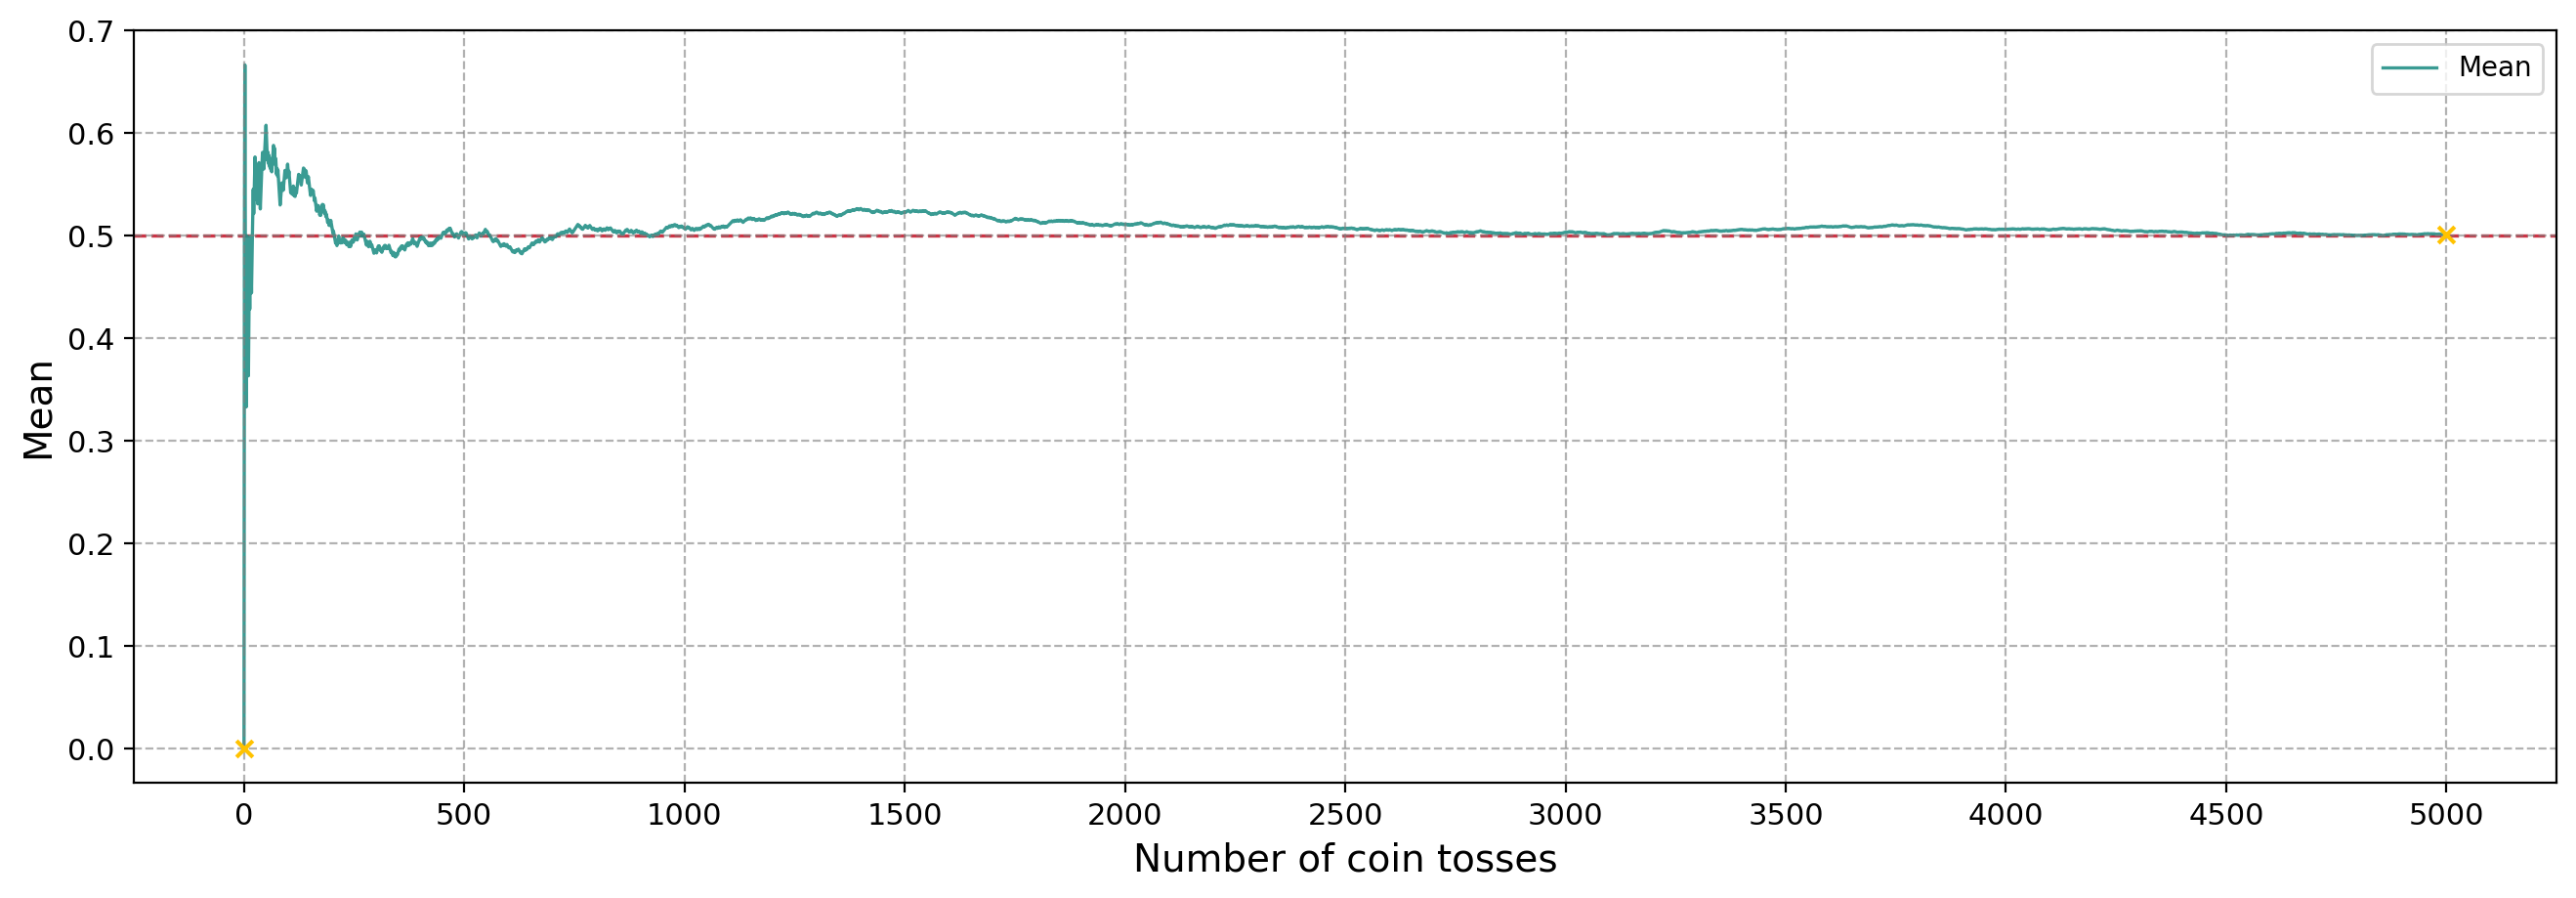

In [81]:
import numpy as np
import matplotlib.pyplot as plt
ite =5000
random_values = np.random.uniform(low=0.0, high=1.0, size=ite)
positive = np.cumsum(random_values > 0.5)
negitive = np.cumsum(random_values <= 0.5)
mean = positive / (positive + negitive)
qing =(36/255, 144/255, 135/255)
hong =(200/255, 29/255, 49/255)
huang = '#FFC200'
plt.figure(figsize=(16, 5), dpi = 200)
plt.axhline(y=0.5, color=hong, alpha = 0.9, linestyle='--', linewidth=1.2, zorder=0)
plt.plot(mean, color=qing,alpha =0.9,label='Mean', linewidth=1.2, zorder=1)
plt.scatter(0, mean[0], marker='x', zorder=2, color=huang)
plt.scatter(len(mean), mean[-1], marker ='x', color =huang, zorder=2)
plt.xlabel('Number of coin tosses', fontsize=14, color='black')
plt.ylabel('Mean', fontsize=14, color='black')
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.8,alpha=0.6, color='gray')
plt.tick_params(axis='both', which='major', labelsize=11,colors='black')
plt.xticks(range(0,len(mean)+1, 500))
plt.legend()
plt.savefig('flip.png',dpi=300, transparent=True)
plt.show()

MC method

In [92]:
import numpy as np
import random
import time
from collections import defaultdict

'''
OX
OI
'''

class SimpleFourStateEnv_MC:

    def __init__(self):
        self.num_states = 4
        self.num_actions = 4 # 0:up, 1:right, 2:down, 3:left
        self.state_coords = {0: (0, 0), 1: (0, 1), 2: (1, 0), 3: (1, 1)}
        self.coords_state = {v: k for k, v in self.state_coords.items()}
        self.rows, self.cols = 2, 2
        self.forbidden_state = 1 # s2 forbidden
        self.target_state = 3    # s4 (terminal)
        self._terminal_states = {self.target_state}

        self.rewards_config = {
            'boundary': -1.0,
            'forbidden': -1.0,
            'target': 1.0,    
            'other': 0.0      
        }

    def step(self, state, action):

        if state in self._terminal_states:
            return state, 0.0, True # Stay in terminal state

        current_row, current_col = self.state_coords[state]
        next_row, next_col = current_row, current_col
        reward = self.rewards_config['other'] 

        if action == 0: next_row -= 1 # up
        elif action == 1: next_col += 1 # right
        elif action == 2: next_row += 1 # down
        elif action == 3: next_col -= 1 # left


        if next_row < 0 or next_row >= self.rows or next_col < 0 or next_col >= self.cols:
            next_state = state 
            reward = self.rewards_config['boundary']
        else:
            next_state = self.coords_state[(next_row, next_col)]

            if next_state == self.target_state:
                reward = self.rewards_config['target']
            elif next_state == self.forbidden_state:
                 reward = self.rewards_config['forbidden']

        done = (next_state in self._terminal_states)
        return next_state, reward, done

    def get_random_start_state(self):

        possible_starts = [s for s in range(self.num_states) if s not in self._terminal_states]
        return random.choice(possible_starts)
    
    def is_terminal(self, state):
         return state in self._terminal_states

# Epsilon-Greedy Policy Creation
def create_epsilon_greedy_policy(Q, epsilon, num_actions):

    def policy_fn(state):
        if random.random() < epsilon:
            # Explore: choose a random action
            return random.choice(range(num_actions))
        else:
            # Exploit: choose the best action based on current Q values
            # Q[state] will default to zeros if state not seen yet
            q_values = Q[state]
            best_action_indices = np.where(q_values == np.max(q_values))[0]
            return random.choice(best_action_indices)
    return policy_fn

# Monte Carlo Control Algorithm (On-Policy, Every-Visit, Epsilon-Greedy)
def mc_control_epsilon_greedy(env, num_episodes, gamma=0.9, epsilon=0.1):
   
    num_actions = env.num_actions
    num_states = env.num_states

    # Initialize Q(s, a) arbitrarily (e.g., zeros)
    # Use defaultdict for convenient handling of unseen states
    Q = defaultdict(lambda: np.zeros(num_actions))
    # Keep track of returns and counts for averaging Q(s,a)
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    print(f"Starting MC Control with Epsilon-Greedy (eps={epsilon}, gamma={gamma})")

    for i_episode in range(1, num_episodes + 1):
        if i_episode % (num_episodes // 10) == 0:
            print(f"\rEpisode {i_episode}/{num_episodes}", end="")

        # Create the epsilon-greedy policy based on current Q
        policy = create_epsilon_greedy_policy(Q, epsilon, num_actions)

        # Generate an episode using the current policy
        episode = []
        state = env.get_random_start_state() # Start from a random non-terminal state
        while True:
            action = policy(state)
            next_state, reward, done = env.step(state, action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        # Process the episode: Calculate returns and update Q
        G = 0.0 # Initialize return

        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward # Calculate return G_t from step t

            # Every-Visit MC Update
            # Increment count and sum for the visited (s, a) pair
            pair = (state, action)
            returns_sum[pair] += G
            returns_count[pair] += 1.0

            # Update Q(s, a) using the average return
            Q[state][action] = returns_sum[pair] / returns_count[pair]

    print("\nMC Control finished.")
    # Extract the final greedy policy from the learned Q values
    final_policy = np.zeros(num_states, dtype=int)
    for s in range(num_states):
         if s not in env._terminal_states: # Policy for non-terminal states
             final_policy[s] = np.argmax(Q[s])
         else:
             final_policy[s] = -1 

    return Q, final_policy

def print_policy_mc(policy, env, shape=(2,2)):
    """ Helper function to print the policy grid """
    action_symbols = {0: '^ (up)', 1: '> (right)', 2: 'v (down)', 3: '< (left)', 4: 'o (saty)'}
    policy_grid = np.full(shape, '', dtype=object)
    coords_state = env.coords_state

    for r_idx in range(shape[0]):
        for c_idx in range(shape[1]):
            state_idx = coords_state.get((r_idx, c_idx), -99)
            if state_idx == -99: continue

            if env.is_terminal(state_idx):
                 policy_grid[r_idx, c_idx] = 'Term' 
            else:
                 action_idx = policy[state_idx]
                 policy_grid[r_idx, c_idx] = action_symbols.get(action_idx)
    print("Learned Policy Grid:")
    print(policy_grid)


if __name__ == "__main__":
    print("Running On-Policy Every-Visit MC Control (Epsilon-Greedy)")
    env_mc = SimpleFourStateEnv_MC()
    num_episodes_mc = 100000 # MC episodes
    gamma_mc = 0.9 
    epsilon_mc = 0.1

    start_time = time.time()
    Q_learned, policy_learned = mc_control_epsilon_greedy(env_mc, num_episodes_mc, gamma=gamma_mc, epsilon=epsilon_mc)
    end_time = time.time()

    print(f"\nCalculation took {end_time - start_time:.2f} seconds")

    print("\nLearned Action Values (Q):")
    all_states = range(env_mc.num_states)
    for s in sorted(all_states):
        q_vals_list = Q_learned[s] 
        q_vals_str = [f"{q:.3f}" for q in q_vals_list]
        print(f"  State {s} (s{s+1}): ", end="")
        print(f"[Up:{q_vals_str[0]}, Right:{q_vals_str[1]}, Down:{q_vals_str[2]}, Left:{q_vals_str[3]}]")


    print("\nFinal Greedy Policy derived from Q:")
    print_policy_mc(policy_learned, env=env_mc, shape=(env_mc.rows, env_mc.cols))

Running On-Policy Every-Visit MC Control (Epsilon-Greedy)
Starting MC Control with Epsilon-Greedy (eps=0.1, gamma=0.9)
Episode 100000/100000
MC Control finished.

Calculation took 1.05 seconds

Learned Action Values (Q):
  State 0 (s1): [Up:-0.318, Right:-0.155, Down:0.842, Left:-0.325]
  State 1 (s2): [Up:-0.171, Right:-0.180, Down:1.000, Left:0.683]
  State 2 (s3): [Up:0.685, Right:1.000, Down:-0.162, Left:-0.158]
  State 3 (s4): [Up:0.000, Right:0.000, Down:0.000, Left:0.000]

Final Greedy Policy derived from Q:
Learned Policy Grid:
[['v (down)' 'v (down)']
 ['> (right)' 'Term']]
